## Context Based Synthetic QA Dataset

In [1]:
# | eval: false
import umap
from os import environ
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from typing import Any, Dict, Generator, Iterable, List
from datasets import Dataset
from pymongo import MongoClient
from loguru import logger
import pandas as pd
from tqdm.notebook import tqdm

from juddges.settings import PL_JUDGEMENTS_SYNTH_QA_PATH, CHARTS_DIR, CACHE_DIR
from juddges.data.utils import read_jsonl
from juddges.data.models import DatasetContextType

In [2]:
synth_qa_records_fpath = (
    PL_JUDGEMENTS_SYNTH_QA_PATH
    / "judgements_sample50_synth_qa__Chain-of-Thought__gpt-3.5-turbo__20240531_201317f666740.jsonl"
)

In [3]:
client = MongoClient(environ["MONGO_URI"])

## HuggingFace Dataset Crafting

In [4]:
def _gen_records(mongo_client: MongoClient) -> Generator[Dict[str, str], None, None]:
    mongo_collection = mongo_client["juddges"]["judgements"]
    for synth_qas in read_jsonl(synth_qa_records_fpath):
        context_id = synth_qas["metadata"]["judgement_id"]

        doc = mongo_collection.find_one({"_id": context_id})
        if doc is None:
            continue
        context = doc["text"]
        if context is None:
            logger.warning(f"Judgement with id {context_id} not found in the database")
            continue

        for question, answer in zip(synth_qas["questions"], synth_qas["answers"]):
            yield {
                "question": question,
                "answer": answer,
                "context": context,
                "context_id": context_id,
                "context_type": DatasetContextType.JUDGEMENTS,
                "language": synth_qas["metadata"]["language"],
            }


# features_dtypes = {
#     "question": str,
#     "answer": str,
#     "context": str,
#     "context_id": str,
#     "context_type": str,
#     "language": str,
# }
# gen_kwargs = {"mongo_client": client}
# dataset = Dataset.from_generator(
#     _gen_records,
#     features=features_dtypes,
#     gen_kwargs=gen_kwargs,
# )
# dataset

In [5]:
synth_qa_df = pd.DataFrame.from_records(_gen_records(client))
synth_qa_df

,question,answer,context,context_id,context_type,language
0,Kto był przewodniczącym rozprawy?,Sędzia Elżbieta Gawryszczak,Sygn. akt: III Ca 2630/19\n\nPOSTANOWIENIE\nDn...,152510000001503_III_Ca_002630_2019_Uz_2021-05-...,DatasetContextType.JUDGEMENTS,pl
1,Kto był protokolantem podczas rozprawy?,staż. Alicja Pisarczyk,Sygn. akt: III Ca 2630/19\n\nPOSTANOWIENIE\nDn...,152510000001503_III_Ca_002630_2019_Uz_2021-05-...,DatasetContextType.JUDGEMENTS,pl
2,Co było przedmiotem rozprawy?,Podział majątku wspólnego,Sygn. akt: III Ca 2630/19\n\nPOSTANOWIENIE\nDn...,152510000001503_III_Ca_002630_2019_Uz_2021-05-...,DatasetContextType.JUDGEMENTS,pl
3,Jakie postanowienie zostało podjęte w sprawie?,"Oddalenie apelacji uczestniczki, zmiana zaskar...",Sygn. akt: III Ca 2630/19\n\nPOSTANOWIENIE\nDn...,152510000001503_III_Ca_002630_2019_Uz_2021-05-...,DatasetContextType.JUDGEMENTS,pl
4,Kto został obciążony kosztami postępowania ape...,Każdy z uczestników,Sygn. akt: III Ca 2630/19\n\nPOSTANOWIENIE\nDn...,152510000001503_III_Ca_002630_2019_Uz_2021-05-...,DatasetContextType.JUDGEMENTS,pl
...,...,...,...,...,...,...
225,Na jakiej podstawie sąd uniewinnił obwinionego?,Na podstawie art. 119 § 2 k.p.o.w.,Sygn. akt II W 3/20\n\nWYROK\nW IMIENIU RZECZY...,155005100001006_II_W_000003_2020_Uz_2021-02-12...,DatasetContextType.JUDGEMENTS,pl
226,"Dlaczego sąd uznał, że obwiniony nie jest winny?",Brak obiektywnych dowodów i nieprzekonywujące ...,Sygn. akt II W 3/20\n\nWYROK\nW IMIENIU RZECZY...,155005100001006_II_W_000003_2020_Uz_2021-02-12...,DatasetContextType.JUDGEMENTS,pl
227,Kto był świadkiem podczas zdarzenia?,J. M. (1),Sygn. akt II W 3/20\n\nWYROK\nW IMIENIU RZECZY...,155005100001006_II_W_000003_2020_Uz_2021-02-12...,DatasetContextType.JUDGEMENTS,pl
228,Czy sąd uznał zeznania świadka za wiarygodne?,"Nie, ze względu na konflikty z obwinionym.",Sygn. akt II W 3/20\n\nWYROK\nW IMIENIU RZECZY...,155005100001006_II_W_000003_2020_Uz_2021-02-12...,DatasetContextType.JUDGEMENTS,pl


In [6]:
synth_qa_df[["question", "answer", "context"]].nunique()

question    218
answer      226
context      44
dtype: int64

In [7]:
synth_qa_df[synth_qa_df["question"].duplicated()]

,question,answer,context,context_id,context_type,language
71,Kto był protokolantem sprawy?,Katarzyna Kuchta,Sygn. akt: I C 53/19\n\nWYROK\nW IMIENIU RZECZ...,151515000000503_I_C_000053_2019_Uz_2020-02-18_001,DatasetContextType.JUDGEMENTS,pl
82,Kto był przewodniczącym sądu?,Bogusław Suter,Sygn. akt I AGa 119/18\n\nWYROK\nW IMIENIU RZE...,150500000000503_I_AGa_000119_2018_Uz_2018-09-1...,DatasetContextType.JUDGEMENTS,pl
110,Kto był przewodniczącym sprawy?,SSO Katarzyna Banko,Sygn. akt:I C 267/12\n\nWYROK\nW IMIENIU RZECZ...,151515000000503_I_C_000267_2012_Uz_2014-10-28_002,DatasetContextType.JUDGEMENTS,pl
126,Kto był protokolantem w sprawie?,Katarzyna Wikiera,sygn. akt IV Ka 583/19\n\nWYROK\nW IMIENIU RZE...,155025000002006_IV_Ka_000583_2019_Uz_2020-03-0...,DatasetContextType.JUDGEMENTS,pl
168,Kto był protokolantem?,Protokolantem był sekr. sąd. M. C.,WYROK\nW IMIENIU RZECZYPOSPOLITEJ POLSKIEJ\nDn...,152510000004021_VIII_U_001745_2015_Uz_2016-05-...,DatasetContextType.JUDGEMENTS,pl
172,Kto był protokolantem podczas rozprawy?,sekretarz sądowy Emilia Kowalczyk,Sygn. akt:III U 1045/13\n\nWYROK\nW IMIENIU RZ...,150525000001521_III_U_001045_2013_Uz_2015-05-2...,DatasetContextType.JUDGEMENTS,pl
177,Kto był przewodniczącym sądu w tej sprawie?,Artur Piotr Wewióra,XVIII C 3656/17\n\nWYROK\nW IMIENIU RZECZYPOSP...,152510100005403_XVIII_C_003656_2017_Uz_2018-02...,DatasetContextType.JUDGEMENTS,pl
178,Kto był protokolantem w tej sprawie?,Beata Kowalska,XVIII C 3656/17\n\nWYROK\nW IMIENIU RZECZYPOSP...,152510100005403_XVIII_C_003656_2017_Uz_2018-02...,DatasetContextType.JUDGEMENTS,pl
183,Kto był przewodniczącym sądu?,Joanna Kończyk,Sygn. akt IC 220/15\n\nWYROK\nW IMIENIU RZECZY...,151020200000503_I_C_000220_2015_Uz_2016-05-20_001,DatasetContextType.JUDGEMENTS,pl
194,Kto był przewodniczącym sądu w tym przypadku?,Ryszard Myrda,sygn. akt IC 1391/21\n\nWYROK W IMIENIU\n\nRZE...,151510050000503_I_C_001391_2021_Uz_2021-10-13_001,DatasetContextType.JUDGEMENTS,pl


In [8]:
synth_qa_df[synth_qa_df["answer"].duplicated()]

,question,answer,context,context_id,context_type,language
79,Kto został spadkobiercą na podstawie testamentu?,A. P. (1),I Ca 121/20\n\nUZASADNIENIE\nWnioskodawczyniA....,151010000000503_I_Ca_000121_2020_Uz_2020-10-26...,DatasetContextType.JUDGEMENTS,pl
99,Kto był właścicielem gospodarstwa rolnego?,M. S.,Sygn. akt IV U 568/18\n\nWYROK\nW IMIENIU RZEC...,151510000002021_IV_U_000568_2018_Uz_2018-11-14...,DatasetContextType.JUDGEMENTS,pl
143,Kto był wydawcą tej decyzji?,Dorota Szubska,Sygn. akt: III AUa 946/13\n\nWYROK\nW IMIENIU ...,152500000001521_III_AUa_000946_2013_Uz_2014-02...,DatasetContextType.JUDGEMENTS,pl
229,Na jakiej podstawie sąd wydał orzeczenie o kos...,Na podstawie art. 119 § 2 k.p.o.w.,Sygn. akt II W 3/20\n\nWYROK\nW IMIENIU RZECZY...,155005100001006_II_W_000003_2020_Uz_2021-02-12...,DatasetContextType.JUDGEMENTS,pl


## Calculate embeddings

In [9]:
from juddges.data.utils import get_texts_embeddings

for col in tqdm(["context", "question", "answer"]):
    vectors = get_texts_embeddings(synth_qa_df[col].tolist())
    synth_qa_df[f"{col}_vec"] = vectors

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing 

  0%|          | 0/230 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2438 > 512). Running this sequence through the model will result in indexing errors
/opt/conda/lib/python3.10/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 0.69s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


(230,)
(230, 768)


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing 

  0%|          | 0/230 [00:00<?, ?it/s]

(230,)
(230, 768)


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing 

  0%|          | 0/230 [00:00<?, ?it/s]

(230,)
(230, 768)


In [10]:
for n_components in tqdm([2, 3], position=0, leave=True):
    reducer = umap.UMAP(n_components=n_components, random_state=42)
    reducer.fit(
        synth_qa_df[["context_vec", "question_vec", "answer_vec"]].values.flatten().tolist()
    )
    for col in tqdm(["context", "question", "answer"], position=1, leave=False):
        reduced_vec = reducer.transform(synth_qa_df[f"{col}_vec"].tolist()).tolist()
        synth_qa_df[f"{col}_vec_{n_components}d"] = reduced_vec

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


  0%|          | 0/3 [00:00<?, ?it/s]

## Visualize Semantic Similarity

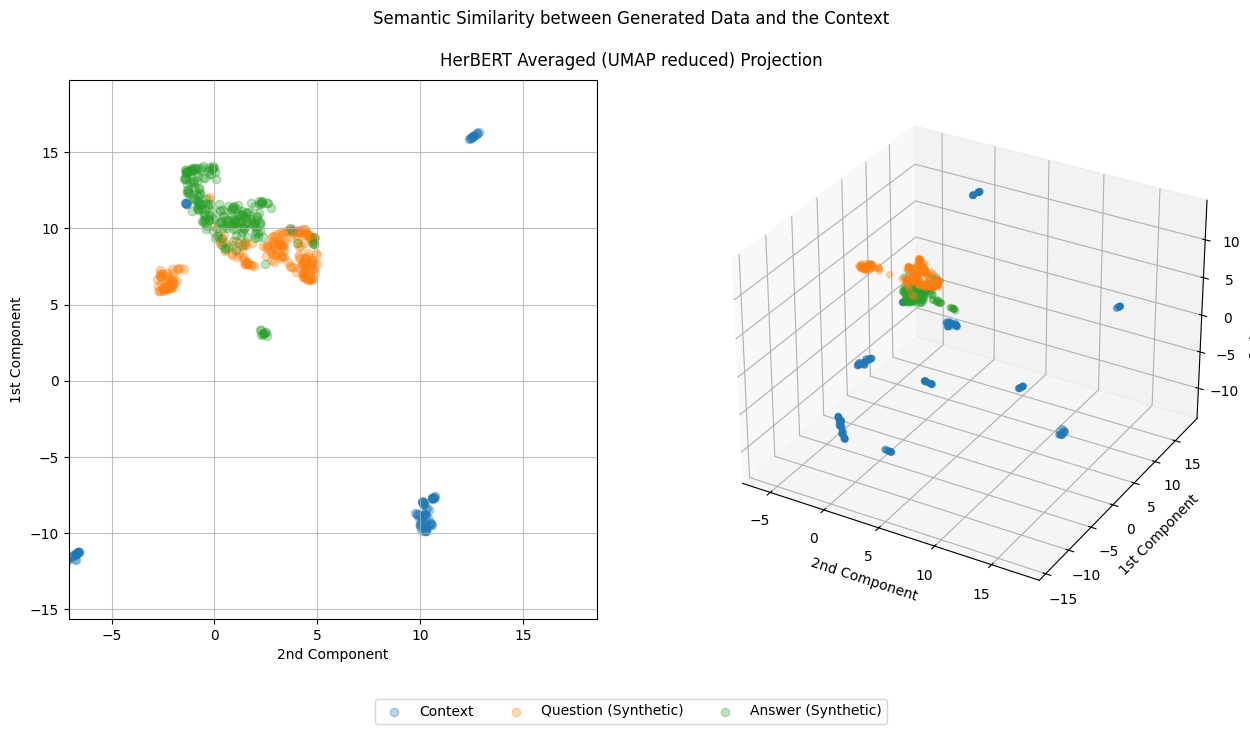

In [11]:
import matplotlib.pyplot as plt

point_alpha = 0.3

fig = plt.figure(figsize=(15, 7))
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection="3d", sharex=ax2d, sharey=ax2d)

for col in ["context", "question", "answer"]:
    xs, ys = zip(*synth_qa_df[f"{col}_vec_2d"].tolist())
    ax2d.scatter(xs, ys, alpha=point_alpha, label=col.capitalize())
ax2d.set_ylabel("1st Component")
ax2d.set_xlabel("2nd Component")
ax2d.grid(alpha=0.8)

for col in ["context", "question", "answer"]:
    xs, ys, zs = zip(*synth_qa_df[f"{col}_vec_3d"].tolist())
    ax3d.scatter(xs, ys, zs, alpha=point_alpha, label=col.capitalize())
ax3d.set_ylabel("1st Component")
ax3d.set_xlabel("2nd Component")
ax3d.set_zlabel("3rd Component")
ax3d.set_xlim(ax2d.get_xlim())
ax3d.set_ylim(ax2d.get_ylim())

fig.legend(
    ["Context", "Question (Synthetic)", "Answer (Synthetic)"],
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.05),
)
fig.suptitle(
    "Semantic Similarity between Generated Data and the Context\n\nHerBERT Averaged (UMAP reduced) Projection\n"
)
# plt.tight_layout()
plt.show()

fig.savefig(str(CHARTS_DIR / f"herbert_umap_projection__{synth_qa_records_fpath.stem}.png"))

## Sentiment Comparison

In [12]:
from juddges.data.utils import get_texts_sentiment

id2sentiment = {0: "negative", 1: "neutral", 2: "positive"}
sent_col_dfs = []
for col in tqdm(["context", "question", "answer"]):
    sentiment_scores = get_texts_sentiment(synth_qa_df[col].unique().tolist())
    sent_col_df = pd.DataFrame(sentiment_scores, columns=id2sentiment.values())
    sent_col_df["resource"] = col
    sent_col_dfs.append(sent_col_df)

sentiment_df = pd.concat(sent_col_dfs, axis="index")
sentiment_df

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/44 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/218 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/226 [00:00<?, ?it/s]

,negative,neutral,positive,resource
0,-0.896473,1.214325,-0.544993,context
1,1.169088,0.369506,-1.265293,context
2,1.288476,1.166252,-2.042488,context
3,-0.407230,1.744358,-0.840606,context
4,0.716870,0.833668,-1.111299,context
...,...,...,...,...
221,2.724617,-0.031870,-2.376428,answer
222,-2.336100,2.424836,0.059899,answer
223,2.128894,0.573218,-2.313244,answer
224,-1.956587,0.479577,1.825817,answer


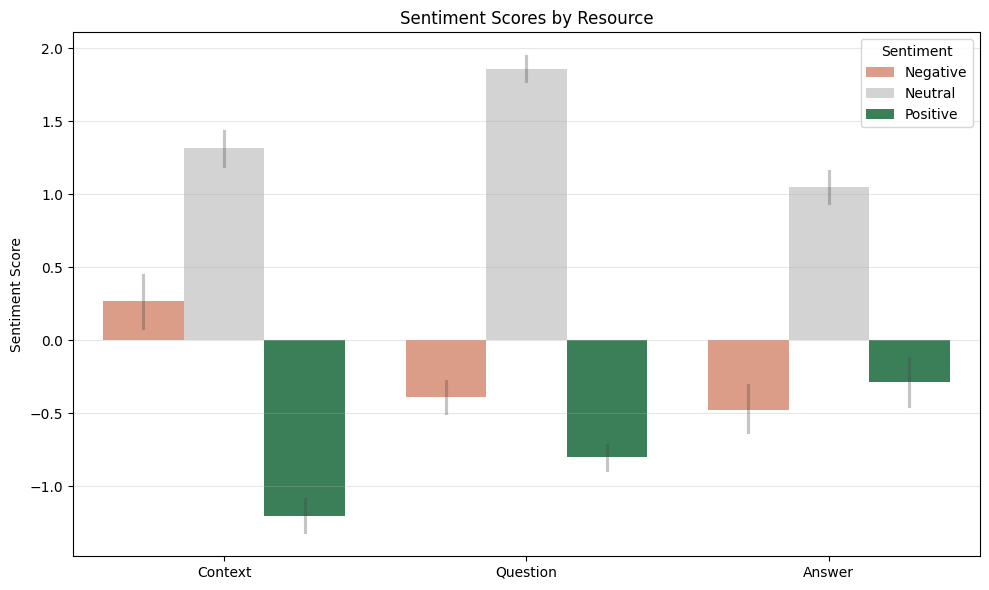

In [13]:
# Reorder dataframe
sent_vis_df = sentiment_df.rename(columns={col: col.capitalize() for col in id2sentiment.values()})
sent_vis_df["resource"] = sent_vis_df["resource"].str.capitalize()
sent_vis_df = sent_vis_df.melt(id_vars=['resource'], value_vars=map(lambda x: x.capitalize(), id2sentiment.values()), var_name='Sentiment', value_name='Score')

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=sent_vis_df,
    x='resource',
    y='Score',
    hue='Sentiment',
    ax=ax,
    palette={'Negative': 'darksalmon', 'Neutral': 'lightgray', 'Positive': 'seagreen'},
    err_kws={"alpha": 0.3}
)

# Adding titles and labels
ax.set_title('Sentiment Scores by Resource')
ax.set_ylabel('Sentiment Score')
ax.set_xlabel(None)

plt.legend(title='Sentiment')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

fig.savefig(str(CHARTS_DIR / f"sentiment_comp__{synth_qa_records_fpath.stem}.png"))

## Formality Comparison

In [14]:
from juddges.data.utils import get_texts_formality

id2formality = {0: "formal", 1: "informal"}
formality_col_dfs = []
for col in tqdm(["context", "question", "answer"]):
    formality_scores = get_texts_formality(synth_qa_df[col].unique().tolist())
    formality_col_df = pd.DataFrame(formality_scores, columns=id2formality.values())
    formality_col_df["resource"] = col
    formality_col_dfs.append(formality_col_df)

formality_df = pd.concat(formality_col_dfs, axis="index")
formality_df

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/44 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/218 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/226 [00:00<?, ?it/s]

,formal,informal,resource
0,0.958910,0.041090,context
1,0.572146,0.427854,context
2,0.887943,0.112057,context
3,0.989007,0.010993,context
4,0.634778,0.365222,context
...,...,...,...
221,0.989566,0.010434,answer
222,0.836116,0.163884,answer
223,0.998612,0.001388,answer
224,0.934406,0.065594,answer


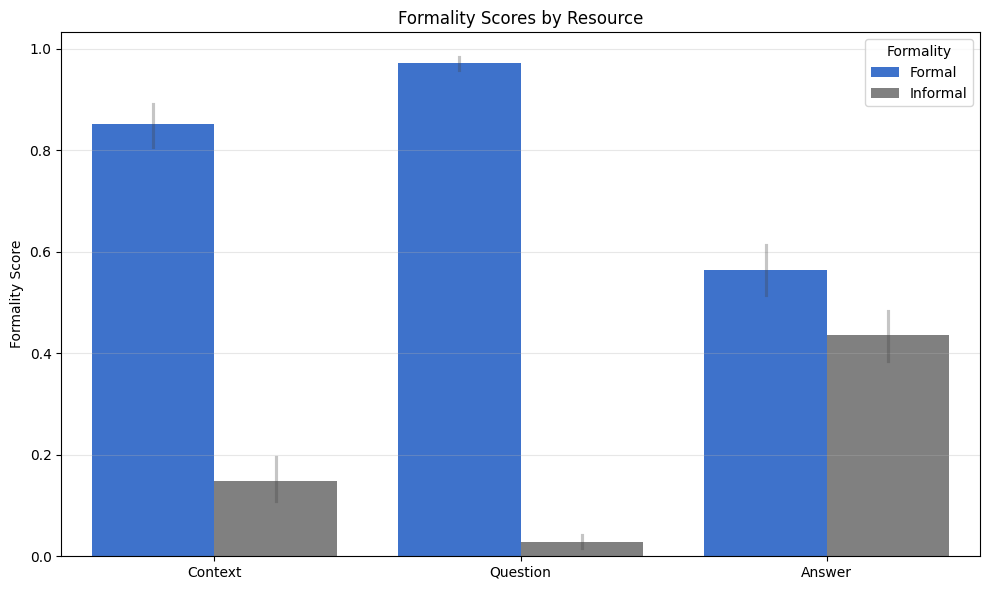

In [15]:
# Reorder dataframe
formality_vis_df = formality_df.rename(columns={col: col.capitalize() for col in id2formality.values()})
formality_vis_df["resource"] = formality_vis_df["resource"].str.capitalize()
formality_vis_df = formality_vis_df.melt(id_vars=['resource'], value_vars=map(lambda x: x.capitalize(), id2formality.values()), var_name='Formality', value_name='Score')

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=formality_vis_df,
    x='resource',
    y='Score',
    hue='Formality',
    ax=ax,
    palette={'Informal': 'gray', 'Formal': '#266CE3'},
    err_kws={"alpha": 0.3}
)

# Adding titles and labels
ax.set_title('Formality Scores by Resource')
ax.set_ylabel('Formality Score')
ax.set_xlabel(None)

plt.legend(title='Formality')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

fig.savefig(str(CHARTS_DIR / f"formality_comp__{synth_qa_records_fpath.stem}.png"))